# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from accelerate import Accelerator, notebook_launcher
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()
farthest_point = manager.dict()

# Non shared resources
filename = 'netifier-coreset-kfold'
epochs = 10
batch_size = 32
sequence_length = 96
min_increment = 200

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/netifier-2/netifier/processed_train.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/netifier-2/netifier/processed_test.csv', encoding='latin-1')

data = pd.concat([train_data, val_data], ignore_index=True)
data.shape

(7773, 7)

In [7]:
data.head()

,original_text,source,pornografi,sara,radikalisme,pencemaran_nama_baik,processed_text
0,[QUOTE=jessepinkman16;5a50ac34d89b093f368b456e...,kaskus,0,0,0,1,jabar memang provinsi barokah boleh juga dan n...
1,"@verosvante kita2 aja nitizen yang pada kepo,t...",instagram,0,0,0,0,kita saja nitizen yang pada penasaran toh kelu...
2,"""#SidangAhok smg sipenista agama n ateknya mat...",twitter,0,1,1,1,sidangahok semoga sipenista agama dan ateknya ...
3,@bolususulembang.jkt barusan baca undang2 ini....,instagram,0,0,0,0,jakarta barusan baca undang ini tetap dibedaka...
4,bikin anak mulu lu nof \nkaga mikir apa kasian...,kaskus,0,0,0,0,buat anak melulu kamu nof nkaga mikir apa kasi...


# BUILD DATASET & DATALOADERS

In [8]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import numpy as np
import torch

# Define custom Dataset class
class NetifierDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=96):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

In [9]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=96, num_workers=4):
    train_dataset = NetifierDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = NetifierDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [10]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'],
        zero_division=0
    ) 

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [11]:
def train_model(current_train_size, train_indices, metrics, trials, seed, X_train_fold, y_train_fold, X_val_fold, y_val_fold, label_columns):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(f"Fold {trials + 1} - Training with {current_train_size} samples...")

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(label_columns),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders using the fold's data
    current_X_train = [X_train_fold[i] for i in train_indices]
    current_y_train = [y_train_fold[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val_fold, y_val_fold)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-fold-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result
        
        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Best result for {current_train_size} samples: F1 Micro: {round(best_result['f1_micro'], 4)}")
    accelerator.print(best_result['report'])
    
    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [12]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [13]:
def coreset_sampling(model, farthest_point, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, X_train_fold, y_train_fold, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device
    model.to(device)

    current_train_size = len(train_indices)
    dataset = NetifierDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
        shuffle=False,
    )
    farthest_data = dict(farthest_point)
    
    model.eval()
    start_time = time.time()
    embeddings = []
    
    for data in dataloader:
        input_ids = data['input_ids'].to(device, non_blocking=True)
        attention_mask = data['attention_mask'].to(device, non_blocking=True)
        with torch.no_grad():
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)

        hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
        embeddings.append(hidden_states.cpu().numpy())

    if 'input_ids' in farthest_data:
        with torch.no_grad():
            outputs = model.base_model(
                input_ids=farthest_data['input_ids'].unsqueeze(0).to(device, non_blocking=True), 
                attention_mask=farthest_data['attention_mask'].unsqueeze(0).to(device, non_blocking=True)
            )
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())
    
    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        # Use pairwise distances to compute a distance matrix for Coreset selection
        distance_matrix = pairwise_distances(embeddings)    
        selected_indices = distance_matrix.shape[0] - 1 if 'input_ids' in farthest_data else 0
        
        # Calculate the minimum distance from selected points to all other points
        min_distances = distance_matrix[selected_indices]

        sorted_dist = np.argsort(min_distances)
        sorted_dist = sorted_dist[::-1]
        farthest_point['input_ids'] = dataset[sorted_dist[0]]['input_ids']
        farthest_point['attention_mask'] = dataset[sorted_dist[0]]['attention_mask']
                
        threshold = np.percentile(min_distances, 90)
        candidates = np.where(min_distances >= threshold)[0]  # Select the point farthest from the current set
        num_of_candidates = len(candidates)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            selected_indices = sorted_dist[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
             selected_indices = sorted_dist[:max(n_samples, min(math.ceil(0.1*len(sorted_dist)), num_of_candidates))]
        else:
            selected_indices = sorted_dist[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in selected_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train_fold[i] for i in temp],
                'pornografi': [y_train_fold[i][0] for i in temp],
                'sara': [y_train_fold[i][1] for i in temp],
                'radikalisme': [y_train_fold[i][2] for i in temp],
                'pencemaran_nama_baik': [y_train_fold[i][3] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in selected_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(selected_indices))
        print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [14]:
from sklearn.model_selection import KFold

N_SPLITS = 5
RANDOM_SEED = 42

# Prepare data for K-Fold
label_columns = data.columns[2:6]
X = data['processed_text'].values
y = data[label_columns].values
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)

all_fold_accuracies = []
all_fold_f1_micros = []
all_fold_f1_macros = []
all_fold_data_used = []

for fold, (train_index, val_index) in enumerate(kf.split(X)):
    if fold >= 3:
        print("===============================================")
        print(f"STARTING FOLD {fold + 1}/{N_SPLITS}")
        print("===============================================")
    
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]
    
        train_fold_df = pd.DataFrame(X_train_fold, columns=['processed_text'])
        train_fold_df[label_columns] = y_train_fold
    
        val_fold_df = pd.DataFrame(X_val_fold, columns=['processed_text'])
        val_fold_df[label_columns] = y_val_fold
    
        fold_data_dir = 'kfold_splits'
        if not os.path.exists(fold_data_dir):
            os.makedirs(fold_data_dir)
    
        train_fold_df.to_csv(f'{fold_data_dir}/train_fold_{fold + 1}.csv', index=False)
        val_fold_df.to_csv(f'{fold_data_dir}/val_fold_{fold + 1}.csv', index=False)
    
        # Shared resources for this fold's processes
        accuracies = manager.list()
        f1_micros = manager.list()
        f1_macros = manager.list()
        data_used = manager.list()
        sampling_dur = manager.list()
        farthest_point = manager.dict()
        
        set_seed(RANDOM_SEED + fold)
        
        # Define the initial labeled pool from the current fold's training data
        total_train_fold_size = len(X_train_fold) + len(X_val_fold)
        initial_train_size = int(0.05 * total_train_fold_size)
        
        train_indices = np.random.choice(range(len(X_train_fold)), initial_train_size, replace=False).tolist()
        remaining_indices = list(set(range(len(X_train_fold))) - set(train_indices))
        current_train_size = initial_train_size
    
        checkpoints = [
            # int(0.1 * total_train_fold_size),
            int(0.5 * total_train_fold_size), 
            int(0.6 * total_train_fold_size),
            int(0.7 * total_train_fold_size),
            len(X_train_fold)
        ]
        
        fold_start_time = time.time()
        
        while current_train_size < total_train_fold_size:
            # Train the model on the current labeled set
            train_args = (
                current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros),
                fold, RANDOM_SEED + fold, X_train_fold, y_train_fold, X_val_fold, y_val_fold, label_columns
            )
            notebook_launcher(train_model, train_args, num_processes=2)
            
            # Stop if we've reached the last checkpoint
            if current_train_size >= checkpoints[-1]:
                break
    
            model = BertForSequenceClassification.from_pretrained(f'{filename}-fold-{fold + 1}-model')
            
            # Perform query strategy to select new samples
            new_samples_shared = manager.list()
            X_pool = [X_train_fold[i] for i in remaining_indices]
            sampling_args = (model, farthest_point, X_pool, train_indices, remaining_indices, sampling_dur, new_samples_shared, fold, X_train_fold, y_train_fold)
            notebook_launcher(coreset_sampling, sampling_args, num_processes=2)
            
            # Update the pools
            newly_acquired_indices = list(new_samples_shared)
            train_indices.extend(newly_acquired_indices)
            remaining_indices = list(set(remaining_indices) - set(newly_acquired_indices))
        
            current_train_size = len(train_indices)
            print(f"\nFold {fold + 1} - New train size: {current_train_size}\n")
        
        fold_end_time = time.time()
        print(f"\nFOLD {fold + 1} COMPLETED in {fold_end_time - fold_start_time:.2f} seconds")
        
        # Store the results for this fold
        all_fold_data_used.append(list(data_used))
        all_fold_accuracies.append(list(accuracies))
        all_fold_f1_micros.append(list(f1_micros))
        all_fold_f1_macros.append(list(f1_macros))

STARTING FOLD 4/5
Launching training on 2 GPUs.
Fold 4 - Training with 388 samples...


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5795, Accuracy: 0.7811, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.4796, Accuracy: 0.7811, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 3/10, Train Loss: 0.4106, Accuracy: 0.8267, F1 Micro: 0.3666, F1 Macro: 0.3071
Epoch 4/10, Train Loss: 0.3659, Accuracy: 0.8505, F1 Micro: 0.5812, F1 Macro: 0.5497
Epoch 5/10, Train Loss: 0.3165, Accuracy: 0.8614, F1 Micro: 0.6272, F1 Macro: 0.608
Epoch 6/10, Train Loss: 0.2503, Accuracy: 0.8612, F1 Micro: 0.655, F1 Macro: 0.6302
Epoch 7/10, Train Loss: 0.2107, Accuracy: 0.8628, F1 Micro: 0.6613, F1 Macro: 0.6477
Epoch 8/10, Train Loss: 0.1713, Accuracy: 0.8617, F1 Micro: 0.6757, F1 Macro: 0.6675
Epoch 9/10, Train Loss: 0.1484, Accuracy: 0.8644, F1 Micro: 0.672, F1 Macro: 0.662
Epoch 10/10, Train Loss: 0.1116, Accuracy: 0.8662, F1 Micro: 0.686, F1 Macro: 0.6766
Best result for 388 samples: F1 Micro: 0.686
                      precision    recall  f1-score   support

          pornografi       0.92      0.81      0.86       

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4566, Accuracy: 0.8033, F1 Micro: 0.2899, F1 Macro: 0.18
Epoch 2/10, Train Loss: 0.2625, Accuracy: 0.8234, F1 Micro: 0.3736, F1 Macro: 0.2984
Epoch 3/10, Train Loss: 0.1814, Accuracy: 0.8472, F1 Micro: 0.546, F1 Macro: 0.4911
Epoch 4/10, Train Loss: 0.1483, Accuracy: 0.8606, F1 Micro: 0.6356, F1 Macro: 0.6153
Epoch 5/10, Train Loss: 0.1004, Accuracy: 0.8572, F1 Micro: 0.6026, F1 Macro: 0.5714
Epoch 6/10, Train Loss: 0.0955, Accuracy: 0.8652, F1 Micro: 0.669, F1 Macro: 0.6538
Epoch 7/10, Train Loss: 0.0683, Accuracy: 0.8692, F1 Micro: 0.6765, F1 Macro: 0.6646
Epoch 8/10, Train Loss: 0.0597, Accuracy: 0.8641, F1 Micro: 0.6975, F1 Macro: 0.6889
Epoch 9/10, Train Loss: 0.0459, Accuracy: 0.8708, F1 Micro: 0.6904, F1 Macro: 0.6775
Epoch 10/10, Train Loss: 0.044, Accuracy: 0.8702, F1 Micro: 0.6896, F1 Macro: 0.6759
Best result for 972 samples: F1 Micro: 0.6975
                      precision    recall  f1-score   support

          pornografi       0.90      0.85    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.502, Accuracy: 0.7928, F1 Micro: 0.5565, F1 Macro: 0.5494
Epoch 2/10, Train Loss: 0.2989, Accuracy: 0.8397, F1 Micro: 0.6428, F1 Macro: 0.6498
Epoch 3/10, Train Loss: 0.2679, Accuracy: 0.8675, F1 Micro: 0.6401, F1 Macro: 0.6349
Epoch 4/10, Train Loss: 0.2142, Accuracy: 0.8792, F1 Micro: 0.6948, F1 Macro: 0.6834
Epoch 5/10, Train Loss: 0.1649, Accuracy: 0.8766, F1 Micro: 0.6863, F1 Macro: 0.6658
Epoch 6/10, Train Loss: 0.1194, Accuracy: 0.8792, F1 Micro: 0.721, F1 Macro: 0.7149
Epoch 7/10, Train Loss: 0.0899, Accuracy: 0.8789, F1 Micro: 0.7013, F1 Macro: 0.6857
Epoch 8/10, Train Loss: 0.0679, Accuracy: 0.8778, F1 Micro: 0.7288, F1 Macro: 0.7247
Epoch 9/10, Train Loss: 0.0606, Accuracy: 0.8781, F1 Micro: 0.7216, F1 Macro: 0.7166
Epoch 10/10, Train Loss: 0.0513, Accuracy: 0.8813, F1 Micro: 0.7168, F1 Macro: 0.7087
Best result for 1497 samples: F1 Micro: 0.7288
                      precision    recall  f1-score   support

          pornografi       0.86      0.89

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4342, Accuracy: 0.7578, F1 Micro: 0.5505, F1 Macro: 0.5632
Epoch 2/10, Train Loss: 0.2682, Accuracy: 0.8528, F1 Micro: 0.6399, F1 Macro: 0.6456
Epoch 3/10, Train Loss: 0.2249, Accuracy: 0.8745, F1 Micro: 0.7042, F1 Macro: 0.6971
Epoch 4/10, Train Loss: 0.1715, Accuracy: 0.8839, F1 Micro: 0.6976, F1 Macro: 0.6777
Epoch 5/10, Train Loss: 0.1427, Accuracy: 0.8825, F1 Micro: 0.6843, F1 Macro: 0.666
Epoch 6/10, Train Loss: 0.1143, Accuracy: 0.8877, F1 Micro: 0.7132, F1 Macro: 0.6992
Epoch 7/10, Train Loss: 0.0862, Accuracy: 0.8848, F1 Micro: 0.7173, F1 Macro: 0.7035
Epoch 8/10, Train Loss: 0.0601, Accuracy: 0.8816, F1 Micro: 0.7221, F1 Macro: 0.7167
Epoch 9/10, Train Loss: 0.0469, Accuracy: 0.8861, F1 Micro: 0.7178, F1 Macro: 0.7063
Epoch 10/10, Train Loss: 0.0359, Accuracy: 0.8831, F1 Micro: 0.7296, F1 Macro: 0.7225
Best result for 1970 samples: F1 Micro: 0.7296
                      precision    recall  f1-score   support

          pornografi       0.89      0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4411, Accuracy: 0.8487, F1 Micro: 0.5997, F1 Macro: 0.5884
Epoch 2/10, Train Loss: 0.2719, Accuracy: 0.8817, F1 Micro: 0.7195, F1 Macro: 0.7166
Epoch 3/10, Train Loss: 0.2147, Accuracy: 0.8875, F1 Micro: 0.7404, F1 Macro: 0.7373
Epoch 4/10, Train Loss: 0.1772, Accuracy: 0.893, F1 Micro: 0.7508, F1 Macro: 0.7474
Epoch 5/10, Train Loss: 0.1351, Accuracy: 0.8845, F1 Micro: 0.7447, F1 Macro: 0.7441
Epoch 6/10, Train Loss: 0.1019, Accuracy: 0.8898, F1 Micro: 0.7398, F1 Macro: 0.7373
Epoch 7/10, Train Loss: 0.0774, Accuracy: 0.8936, F1 Micro: 0.7307, F1 Macro: 0.7228
Epoch 8/10, Train Loss: 0.0547, Accuracy: 0.8942, F1 Micro: 0.7439, F1 Macro: 0.737
Epoch 9/10, Train Loss: 0.0487, Accuracy: 0.8891, F1 Micro: 0.7457, F1 Macro: 0.7402
Epoch 10/10, Train Loss: 0.0394, Accuracy: 0.8892, F1 Micro: 0.7301, F1 Macro: 0.7233
Best result for 2395 samples: F1 Micro: 0.7508
                      precision    recall  f1-score   support

          pornografi       0.96      0.82

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4332, Accuracy: 0.8634, F1 Micro: 0.6415, F1 Macro: 0.5933
Epoch 2/10, Train Loss: 0.2587, Accuracy: 0.8902, F1 Micro: 0.734, F1 Macro: 0.729
Epoch 3/10, Train Loss: 0.2045, Accuracy: 0.892, F1 Micro: 0.7473, F1 Macro: 0.7406
Epoch 4/10, Train Loss: 0.1726, Accuracy: 0.8902, F1 Micro: 0.7079, F1 Macro: 0.6931
Epoch 5/10, Train Loss: 0.1337, Accuracy: 0.8891, F1 Micro: 0.7392, F1 Macro: 0.7375
Epoch 6/10, Train Loss: 0.0965, Accuracy: 0.8914, F1 Micro: 0.7515, F1 Macro: 0.7474
Epoch 7/10, Train Loss: 0.0741, Accuracy: 0.8973, F1 Micro: 0.7544, F1 Macro: 0.746
Epoch 8/10, Train Loss: 0.0589, Accuracy: 0.8956, F1 Micro: 0.7315, F1 Macro: 0.7211
Epoch 9/10, Train Loss: 0.0466, Accuracy: 0.8923, F1 Micro: 0.7526, F1 Macro: 0.7463
Epoch 10/10, Train Loss: 0.0352, Accuracy: 0.893, F1 Micro: 0.7537, F1 Macro: 0.75
Best result for 2778 samples: F1 Micro: 0.7544
                      precision    recall  f1-score   support

          pornografi       0.95      0.87     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4211, Accuracy: 0.8716, F1 Micro: 0.6776, F1 Macro: 0.6656
Epoch 2/10, Train Loss: 0.2462, Accuracy: 0.8873, F1 Micro: 0.7459, F1 Macro: 0.7442
Epoch 3/10, Train Loss: 0.2001, Accuracy: 0.8989, F1 Micro: 0.7522, F1 Macro: 0.7383
Epoch 4/10, Train Loss: 0.1593, Accuracy: 0.9003, F1 Micro: 0.7574, F1 Macro: 0.752
Epoch 5/10, Train Loss: 0.1204, Accuracy: 0.8975, F1 Micro: 0.7481, F1 Macro: 0.7404
Epoch 6/10, Train Loss: 0.1064, Accuracy: 0.8914, F1 Micro: 0.7622, F1 Macro: 0.7594
Epoch 7/10, Train Loss: 0.0697, Accuracy: 0.8919, F1 Micro: 0.7539, F1 Macro: 0.75
Epoch 8/10, Train Loss: 0.0542, Accuracy: 0.8975, F1 Micro: 0.7588, F1 Macro: 0.7501
Epoch 9/10, Train Loss: 0.045, Accuracy: 0.8984, F1 Micro: 0.7469, F1 Macro: 0.7352
Epoch 10/10, Train Loss: 0.0367, Accuracy: 0.895, F1 Micro: 0.757, F1 Macro: 0.7481
Best result for 3123 samples: F1 Micro: 0.7622
                      precision    recall  f1-score   support

          pornografi       0.93      0.87    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4038, Accuracy: 0.8759, F1 Micro: 0.7042, F1 Macro: 0.6999
Epoch 2/10, Train Loss: 0.2488, Accuracy: 0.8939, F1 Micro: 0.7583, F1 Macro: 0.7587
Epoch 3/10, Train Loss: 0.2051, Accuracy: 0.9019, F1 Micro: 0.7749, F1 Macro: 0.773
Epoch 4/10, Train Loss: 0.1652, Accuracy: 0.8994, F1 Micro: 0.7692, F1 Macro: 0.7644
Epoch 5/10, Train Loss: 0.1196, Accuracy: 0.8958, F1 Micro: 0.7303, F1 Macro: 0.7169
Epoch 6/10, Train Loss: 0.0879, Accuracy: 0.8991, F1 Micro: 0.7546, F1 Macro: 0.7498
Epoch 7/10, Train Loss: 0.0642, Accuracy: 0.8955, F1 Micro: 0.7563, F1 Macro: 0.7482
Epoch 8/10, Train Loss: 0.0498, Accuracy: 0.8989, F1 Micro: 0.7522, F1 Macro: 0.7435
Epoch 9/10, Train Loss: 0.0407, Accuracy: 0.8966, F1 Micro: 0.7543, F1 Macro: 0.7491
Epoch 10/10, Train Loss: 0.0372, Accuracy: 0.8917, F1 Micro: 0.7522, F1 Macro: 0.7475
Best result for 3433 samples: F1 Micro: 0.7749
                      precision    recall  f1-score   support

          pornografi       0.96      0.8

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3843, Accuracy: 0.8753, F1 Micro: 0.7162, F1 Macro: 0.7067
Epoch 2/10, Train Loss: 0.2342, Accuracy: 0.8711, F1 Micro: 0.7411, F1 Macro: 0.7492
Epoch 3/10, Train Loss: 0.1891, Accuracy: 0.8923, F1 Micro: 0.7651, F1 Macro: 0.7617
Epoch 4/10, Train Loss: 0.1491, Accuracy: 0.9011, F1 Micro: 0.7775, F1 Macro: 0.7748
Epoch 5/10, Train Loss: 0.1147, Accuracy: 0.8966, F1 Micro: 0.7264, F1 Macro: 0.7161
Epoch 6/10, Train Loss: 0.0871, Accuracy: 0.8963, F1 Micro: 0.7617, F1 Macro: 0.7534
Epoch 7/10, Train Loss: 0.0653, Accuracy: 0.8997, F1 Micro: 0.7608, F1 Macro: 0.7541
Epoch 8/10, Train Loss: 0.0487, Accuracy: 0.8975, F1 Micro: 0.7655, F1 Macro: 0.7636
Epoch 9/10, Train Loss: 0.0379, Accuracy: 0.8966, F1 Micro: 0.7591, F1 Macro: 0.7554
Epoch 10/10, Train Loss: 0.031, Accuracy: 0.8952, F1 Micro: 0.7589, F1 Macro: 0.7565
Best result for 3712 samples: F1 Micro: 0.7775
                      precision    recall  f1-score   support

          pornografi       0.94      0.8

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3979, Accuracy: 0.8819, F1 Micro: 0.7156, F1 Macro: 0.7086
Epoch 2/10, Train Loss: 0.2329, Accuracy: 0.8956, F1 Micro: 0.7576, F1 Macro: 0.7597
Epoch 3/10, Train Loss: 0.1933, Accuracy: 0.9053, F1 Micro: 0.7761, F1 Macro: 0.7763
Epoch 4/10, Train Loss: 0.1564, Accuracy: 0.8978, F1 Micro: 0.7526, F1 Macro: 0.752
Epoch 5/10, Train Loss: 0.1122, Accuracy: 0.9022, F1 Micro: 0.7632, F1 Macro: 0.7592
Epoch 6/10, Train Loss: 0.0798, Accuracy: 0.8981, F1 Micro: 0.7517, F1 Macro: 0.7484
Epoch 7/10, Train Loss: 0.0582, Accuracy: 0.9017, F1 Micro: 0.7656, F1 Macro: 0.764
Epoch 8/10, Train Loss: 0.0458, Accuracy: 0.9013, F1 Micro: 0.7624, F1 Macro: 0.7522
Epoch 9/10, Train Loss: 0.0367, Accuracy: 0.8963, F1 Micro: 0.769, F1 Macro: 0.7683
Epoch 10/10, Train Loss: 0.0315, Accuracy: 0.9002, F1 Micro: 0.7672, F1 Macro: 0.7631
Best result for 3886 samples: F1 Micro: 0.7761
                      precision    recall  f1-score   support

          pornografi       0.98      0.84 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3747, Accuracy: 0.8825, F1 Micro: 0.7158, F1 Macro: 0.701
Epoch 2/10, Train Loss: 0.2285, Accuracy: 0.8883, F1 Micro: 0.7513, F1 Macro: 0.7523
Epoch 3/10, Train Loss: 0.1825, Accuracy: 0.9014, F1 Micro: 0.7548, F1 Macro: 0.7497
Epoch 4/10, Train Loss: 0.1485, Accuracy: 0.8992, F1 Micro: 0.7503, F1 Macro: 0.741
Epoch 5/10, Train Loss: 0.1135, Accuracy: 0.9014, F1 Micro: 0.7718, F1 Macro: 0.7695
Epoch 6/10, Train Loss: 0.0789, Accuracy: 0.895, F1 Micro: 0.7565, F1 Macro: 0.75
Epoch 7/10, Train Loss: 0.0641, Accuracy: 0.8981, F1 Micro: 0.7686, F1 Macro: 0.7691
Epoch 8/10, Train Loss: 0.045, Accuracy: 0.8995, F1 Micro: 0.7695, F1 Macro: 0.7677
Epoch 9/10, Train Loss: 0.0365, Accuracy: 0.8934, F1 Micro: 0.7663, F1 Macro: 0.7679
Epoch 10/10, Train Loss: 0.031, Accuracy: 0.8997, F1 Micro: 0.764, F1 Macro: 0.7605
Best result for 4120 samples: F1 Micro: 0.7718
                      precision    recall  f1-score   support

          pornografi       0.92      0.90      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3855, Accuracy: 0.8866, F1 Micro: 0.726, F1 Macro: 0.7198
Epoch 2/10, Train Loss: 0.232, Accuracy: 0.8964, F1 Micro: 0.7579, F1 Macro: 0.7576
Epoch 3/10, Train Loss: 0.1834, Accuracy: 0.9027, F1 Micro: 0.7829, F1 Macro: 0.7797
Epoch 4/10, Train Loss: 0.1483, Accuracy: 0.8998, F1 Micro: 0.7733, F1 Macro: 0.7686
Epoch 5/10, Train Loss: 0.1142, Accuracy: 0.8952, F1 Micro: 0.777, F1 Macro: 0.7772
Epoch 6/10, Train Loss: 0.082, Accuracy: 0.8964, F1 Micro: 0.775, F1 Macro: 0.7732
Epoch 7/10, Train Loss: 0.0647, Accuracy: 0.9017, F1 Micro: 0.7717, F1 Macro: 0.7649
Epoch 8/10, Train Loss: 0.0489, Accuracy: 0.9059, F1 Micro: 0.7762, F1 Macro: 0.7671
Epoch 9/10, Train Loss: 0.0388, Accuracy: 0.9022, F1 Micro: 0.7643, F1 Macro: 0.757
Epoch 10/10, Train Loss: 0.0311, Accuracy: 0.8998, F1 Micro: 0.7777, F1 Macro: 0.7768
Best result for 4330 samples: F1 Micro: 0.7829
                      precision    recall  f1-score   support

          pornografi       0.91      0.90    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3856, Accuracy: 0.8888, F1 Micro: 0.7278, F1 Macro: 0.7155
Epoch 2/10, Train Loss: 0.2333, Accuracy: 0.8986, F1 Micro: 0.7399, F1 Macro: 0.7249
Epoch 3/10, Train Loss: 0.1995, Accuracy: 0.8967, F1 Micro: 0.7699, F1 Macro: 0.7706
Epoch 4/10, Train Loss: 0.156, Accuracy: 0.903, F1 Micro: 0.7811, F1 Macro: 0.7786
Epoch 5/10, Train Loss: 0.1129, Accuracy: 0.8981, F1 Micro: 0.772, F1 Macro: 0.7733
Epoch 6/10, Train Loss: 0.0822, Accuracy: 0.8955, F1 Micro: 0.744, F1 Macro: 0.7408
Epoch 7/10, Train Loss: 0.0745, Accuracy: 0.903, F1 Micro: 0.7794, F1 Macro: 0.775
Epoch 8/10, Train Loss: 0.0466, Accuracy: 0.8997, F1 Micro: 0.7719, F1 Macro: 0.7672
Epoch 9/10, Train Loss: 0.0412, Accuracy: 0.9009, F1 Micro: 0.7661, F1 Macro: 0.7626
Epoch 10/10, Train Loss: 0.0292, Accuracy: 0.8983, F1 Micro: 0.7697, F1 Macro: 0.769
Best result for 4530 samples: F1 Micro: 0.7811
                      precision    recall  f1-score   support

          pornografi       0.89      0.92     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3773, Accuracy: 0.883, F1 Micro: 0.7289, F1 Macro: 0.7272
Epoch 2/10, Train Loss: 0.2393, Accuracy: 0.9016, F1 Micro: 0.763, F1 Macro: 0.7598
Epoch 3/10, Train Loss: 0.1927, Accuracy: 0.9027, F1 Micro: 0.7705, F1 Macro: 0.7716
Epoch 4/10, Train Loss: 0.1582, Accuracy: 0.9016, F1 Micro: 0.7514, F1 Macro: 0.7442
Epoch 5/10, Train Loss: 0.121, Accuracy: 0.8994, F1 Micro: 0.7608, F1 Macro: 0.7528
Epoch 6/10, Train Loss: 0.0823, Accuracy: 0.9022, F1 Micro: 0.764, F1 Macro: 0.7593
Epoch 7/10, Train Loss: 0.0618, Accuracy: 0.9003, F1 Micro: 0.7765, F1 Macro: 0.7762
Epoch 8/10, Train Loss: 0.0501, Accuracy: 0.903, F1 Micro: 0.7799, F1 Macro: 0.7784
Epoch 9/10, Train Loss: 0.0389, Accuracy: 0.8964, F1 Micro: 0.7716, F1 Macro: 0.7718
Epoch 10/10, Train Loss: 0.0302, Accuracy: 0.903, F1 Micro: 0.7708, F1 Macro: 0.7694
Best result for 4663 samples: F1 Micro: 0.7799
                      precision    recall  f1-score   support

          pornografi       0.92      0.90    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3689, Accuracy: 0.8819, F1 Micro: 0.7336, F1 Macro: 0.7298
Epoch 2/10, Train Loss: 0.2325, Accuracy: 0.8986, F1 Micro: 0.7752, F1 Macro: 0.7725
Epoch 3/10, Train Loss: 0.1865, Accuracy: 0.902, F1 Micro: 0.7604, F1 Macro: 0.7603
Epoch 4/10, Train Loss: 0.1509, Accuracy: 0.8995, F1 Micro: 0.7429, F1 Macro: 0.7368
Epoch 5/10, Train Loss: 0.1197, Accuracy: 0.9022, F1 Micro: 0.7709, F1 Macro: 0.77
Epoch 6/10, Train Loss: 0.0832, Accuracy: 0.9039, F1 Micro: 0.7671, F1 Macro: 0.7683
Epoch 7/10, Train Loss: 0.0592, Accuracy: 0.9022, F1 Micro: 0.7681, F1 Macro: 0.7645
Epoch 8/10, Train Loss: 0.0486, Accuracy: 0.9014, F1 Micro: 0.7695, F1 Macro: 0.7669
Epoch 9/10, Train Loss: 0.0333, Accuracy: 0.8986, F1 Micro: 0.7648, F1 Macro: 0.7642
Epoch 10/10, Train Loss: 0.0284, Accuracy: 0.9002, F1 Micro: 0.7679, F1 Macro: 0.7662
Best result for 4863 samples: F1 Micro: 0.7752
                      precision    recall  f1-score   support

          pornografi       0.94      0.87 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3765, Accuracy: 0.8827, F1 Micro: 0.7328, F1 Macro: 0.7305
Epoch 2/10, Train Loss: 0.2417, Accuracy: 0.8972, F1 Micro: 0.7693, F1 Macro: 0.7689
Epoch 3/10, Train Loss: 0.1908, Accuracy: 0.9059, F1 Micro: 0.7727, F1 Macro: 0.7668
Epoch 4/10, Train Loss: 0.1522, Accuracy: 0.9038, F1 Micro: 0.762, F1 Macro: 0.759
Epoch 5/10, Train Loss: 0.1178, Accuracy: 0.9009, F1 Micro: 0.7791, F1 Macro: 0.7757
Epoch 6/10, Train Loss: 0.0839, Accuracy: 0.9028, F1 Micro: 0.7774, F1 Macro: 0.776
Epoch 7/10, Train Loss: 0.0647, Accuracy: 0.8966, F1 Micro: 0.7777, F1 Macro: 0.7804
Epoch 8/10, Train Loss: 0.0495, Accuracy: 0.9003, F1 Micro: 0.7797, F1 Macro: 0.7819
Epoch 9/10, Train Loss: 0.0335, Accuracy: 0.9039, F1 Micro: 0.7795, F1 Macro: 0.7791
Epoch 10/10, Train Loss: 0.029, Accuracy: 0.8981, F1 Micro: 0.7709, F1 Macro: 0.772
Best result for 5063 samples: F1 Micro: 0.7797
                      precision    recall  f1-score   support

          pornografi       0.94      0.89   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3575, Accuracy: 0.8888, F1 Micro: 0.7367, F1 Macro: 0.7349
Epoch 2/10, Train Loss: 0.2307, Accuracy: 0.8942, F1 Micro: 0.7115, F1 Macro: 0.6898
Epoch 3/10, Train Loss: 0.1935, Accuracy: 0.9066, F1 Micro: 0.7787, F1 Macro: 0.775
Epoch 4/10, Train Loss: 0.1527, Accuracy: 0.9019, F1 Micro: 0.7771, F1 Macro: 0.7719
Epoch 5/10, Train Loss: 0.1064, Accuracy: 0.9039, F1 Micro: 0.7655, F1 Macro: 0.7614
Epoch 6/10, Train Loss: 0.0867, Accuracy: 0.8959, F1 Micro: 0.7697, F1 Macro: 0.767
Epoch 7/10, Train Loss: 0.0645, Accuracy: 0.8892, F1 Micro: 0.7694, F1 Macro: 0.7708
Epoch 8/10, Train Loss: 0.0465, Accuracy: 0.9052, F1 Micro: 0.7753, F1 Macro: 0.7724
Epoch 9/10, Train Loss: 0.0369, Accuracy: 0.9041, F1 Micro: 0.7774, F1 Macro: 0.7755
Epoch 10/10, Train Loss: 0.0296, Accuracy: 0.9005, F1 Micro: 0.7678, F1 Macro: 0.7673
Best result for 5263 samples: F1 Micro: 0.7787
                      precision    recall  f1-score   support

          pornografi       0.96      0.85

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.357, Accuracy: 0.8836, F1 Micro: 0.7142, F1 Macro: 0.7118
Epoch 2/10, Train Loss: 0.2415, Accuracy: 0.9053, F1 Micro: 0.7803, F1 Macro: 0.7745
Epoch 3/10, Train Loss: 0.1873, Accuracy: 0.8963, F1 Micro: 0.7763, F1 Macro: 0.7769
Epoch 4/10, Train Loss: 0.1501, Accuracy: 0.8908, F1 Micro: 0.7685, F1 Macro: 0.7691
Epoch 5/10, Train Loss: 0.1148, Accuracy: 0.9067, F1 Micro: 0.7814, F1 Macro: 0.7791
Epoch 6/10, Train Loss: 0.0877, Accuracy: 0.8989, F1 Micro: 0.768, F1 Macro: 0.7664
Epoch 7/10, Train Loss: 0.06, Accuracy: 0.9034, F1 Micro: 0.7783, F1 Macro: 0.7753
Epoch 8/10, Train Loss: 0.046, Accuracy: 0.9003, F1 Micro: 0.7639, F1 Macro: 0.7583
Epoch 9/10, Train Loss: 0.0363, Accuracy: 0.8998, F1 Micro: 0.7611, F1 Macro: 0.7588
Epoch 10/10, Train Loss: 0.0282, Accuracy: 0.8975, F1 Micro: 0.7687, F1 Macro: 0.77
Best result for 5441 samples: F1 Micro: 0.7814
                      precision    recall  f1-score   support

          pornografi       0.93      0.89     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3569, Accuracy: 0.8872, F1 Micro: 0.7334, F1 Macro: 0.7295
Epoch 2/10, Train Loss: 0.2241, Accuracy: 0.9047, F1 Micro: 0.7779, F1 Macro: 0.778
Epoch 3/10, Train Loss: 0.1867, Accuracy: 0.9013, F1 Micro: 0.7828, F1 Macro: 0.7825
Epoch 4/10, Train Loss: 0.1478, Accuracy: 0.8983, F1 Micro: 0.7365, F1 Macro: 0.7234
Epoch 5/10, Train Loss: 0.1131, Accuracy: 0.9042, F1 Micro: 0.7762, F1 Macro: 0.7738
Epoch 6/10, Train Loss: 0.084, Accuracy: 0.9019, F1 Micro: 0.7757, F1 Macro: 0.7725
Epoch 7/10, Train Loss: 0.0566, Accuracy: 0.9056, F1 Micro: 0.781, F1 Macro: 0.7756
Epoch 8/10, Train Loss: 0.0396, Accuracy: 0.9011, F1 Micro: 0.7725, F1 Macro: 0.7674
Epoch 9/10, Train Loss: 0.0341, Accuracy: 0.8978, F1 Micro: 0.7795, F1 Macro: 0.7805
Epoch 10/10, Train Loss: 0.0258, Accuracy: 0.8989, F1 Micro: 0.7791, F1 Macro: 0.7785
Best result for 5641 samples: F1 Micro: 0.7828
                      precision    recall  f1-score   support

          pornografi       0.92      0.89 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3514, Accuracy: 0.8892, F1 Micro: 0.7406, F1 Macro: 0.7406
Epoch 2/10, Train Loss: 0.2275, Accuracy: 0.9013, F1 Micro: 0.7735, F1 Macro: 0.7718
Epoch 3/10, Train Loss: 0.192, Accuracy: 0.9053, F1 Micro: 0.7872, F1 Macro: 0.7861
Epoch 4/10, Train Loss: 0.1498, Accuracy: 0.8878, F1 Micro: 0.7676, F1 Macro: 0.7693
Epoch 5/10, Train Loss: 0.1171, Accuracy: 0.8952, F1 Micro: 0.766, F1 Macro: 0.7644
Epoch 6/10, Train Loss: 0.085, Accuracy: 0.9011, F1 Micro: 0.7748, F1 Macro: 0.7726
Epoch 7/10, Train Loss: 0.0616, Accuracy: 0.9048, F1 Micro: 0.7818, F1 Macro: 0.7803
Epoch 8/10, Train Loss: 0.045, Accuracy: 0.9045, F1 Micro: 0.7748, F1 Macro: 0.7701
Epoch 9/10, Train Loss: 0.0339, Accuracy: 0.8995, F1 Micro: 0.7803, F1 Macro: 0.7809
Epoch 10/10, Train Loss: 0.0271, Accuracy: 0.9003, F1 Micro: 0.7798, F1 Macro: 0.7823
Best result for 5841 samples: F1 Micro: 0.7872
                      precision    recall  f1-score   support

          pornografi       0.93      0.88  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3515, Accuracy: 0.8858, F1 Micro: 0.7485, F1 Macro: 0.7478
Epoch 2/10, Train Loss: 0.2328, Accuracy: 0.9042, F1 Micro: 0.7739, F1 Macro: 0.7694
Epoch 3/10, Train Loss: 0.1831, Accuracy: 0.9038, F1 Micro: 0.7843, F1 Macro: 0.7842
Epoch 4/10, Train Loss: 0.1538, Accuracy: 0.9111, F1 Micro: 0.7903, F1 Macro: 0.7847
Epoch 5/10, Train Loss: 0.1063, Accuracy: 0.902, F1 Micro: 0.7734, F1 Macro: 0.7702
Epoch 6/10, Train Loss: 0.0842, Accuracy: 0.902, F1 Micro: 0.7576, F1 Macro: 0.7551
Epoch 7/10, Train Loss: 0.0597, Accuracy: 0.9005, F1 Micro: 0.7837, F1 Macro: 0.7854
Epoch 8/10, Train Loss: 0.0413, Accuracy: 0.9048, F1 Micro: 0.7818, F1 Macro: 0.7807
Epoch 9/10, Train Loss: 0.0321, Accuracy: 0.8959, F1 Micro: 0.7747, F1 Macro: 0.7736
Epoch 10/10, Train Loss: 0.025, Accuracy: 0.9019, F1 Micro: 0.7747, F1 Macro: 0.7721
Best result for 6041 samples: F1 Micro: 0.7903
                      precision    recall  f1-score   support

          pornografi       0.94      0.89 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3499, Accuracy: 0.8773, F1 Micro: 0.7437, F1 Macro: 0.7438
Epoch 2/10, Train Loss: 0.231, Accuracy: 0.9005, F1 Micro: 0.7766, F1 Macro: 0.7723
Epoch 3/10, Train Loss: 0.1873, Accuracy: 0.9011, F1 Micro: 0.7777, F1 Macro: 0.775
Epoch 4/10, Train Loss: 0.1473, Accuracy: 0.8997, F1 Micro: 0.7699, F1 Macro: 0.762
Epoch 5/10, Train Loss: 0.113, Accuracy: 0.9041, F1 Micro: 0.7711, F1 Macro: 0.7661
Epoch 6/10, Train Loss: 0.0809, Accuracy: 0.8963, F1 Micro: 0.7769, F1 Macro: 0.7764
Epoch 7/10, Train Loss: 0.0596, Accuracy: 0.8981, F1 Micro: 0.7739, F1 Macro: 0.772
Epoch 8/10, Train Loss: 0.0443, Accuracy: 0.8994, F1 Micro: 0.7751, F1 Macro: 0.7758
Epoch 9/10, Train Loss: 0.033, Accuracy: 0.9005, F1 Micro: 0.7701, F1 Macro: 0.7694
Epoch 10/10, Train Loss: 0.0259, Accuracy: 0.8989, F1 Micro: 0.7732, F1 Macro: 0.7713
Best result for 6219 samples: F1 Micro: 0.7777
                      precision    recall  f1-score   support

          pornografi       0.94      0.87    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5439, Accuracy: 0.7891, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.4673, Accuracy: 0.7939, F1 Micro: 0.0449, F1 Macro: 0.0404
Epoch 3/10, Train Loss: 0.421, Accuracy: 0.8194, F1 Micro: 0.2561, F1 Macro: 0.1786
Epoch 4/10, Train Loss: 0.39, Accuracy: 0.8313, F1 Micro: 0.3933, F1 Macro: 0.3032
Epoch 5/10, Train Loss: 0.3375, Accuracy: 0.8416, F1 Micro: 0.4483, F1 Macro: 0.3709
Epoch 6/10, Train Loss: 0.2901, Accuracy: 0.8577, F1 Micro: 0.5902, F1 Macro: 0.5609
Epoch 7/10, Train Loss: 0.2547, Accuracy: 0.8578, F1 Micro: 0.5852, F1 Macro: 0.5546
Epoch 8/10, Train Loss: 0.2265, Accuracy: 0.867, F1 Micro: 0.6411, F1 Macro: 0.6284
Epoch 9/10, Train Loss: 0.174, Accuracy: 0.8655, F1 Micro: 0.6682, F1 Macro: 0.6603
Epoch 10/10, Train Loss: 0.1497, Accuracy: 0.8669, F1 Micro: 0.6611, F1 Macro: 0.6529
Best result for 388 samples: F1 Micro: 0.6682
                      precision    recall  f1-score   support

          pornografi       0.87      0.82      0.84

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3993, Accuracy: 0.802, F1 Micro: 0.3177, F1 Macro: 0.1715
Epoch 2/10, Train Loss: 0.2405, Accuracy: 0.8263, F1 Micro: 0.3349, F1 Macro: 0.2103
Epoch 3/10, Train Loss: 0.1749, Accuracy: 0.8313, F1 Micro: 0.3609, F1 Macro: 0.2432
Epoch 4/10, Train Loss: 0.1565, Accuracy: 0.8514, F1 Micro: 0.5603, F1 Macro: 0.5501
Epoch 5/10, Train Loss: 0.1223, Accuracy: 0.8595, F1 Micro: 0.5676, F1 Macro: 0.528
Epoch 6/10, Train Loss: 0.0939, Accuracy: 0.8684, F1 Micro: 0.6432, F1 Macro: 0.6211
Epoch 7/10, Train Loss: 0.0715, Accuracy: 0.8689, F1 Micro: 0.6669, F1 Macro: 0.6489
Epoch 8/10, Train Loss: 0.0599, Accuracy: 0.8631, F1 Micro: 0.5956, F1 Macro: 0.5569
Epoch 9/10, Train Loss: 0.0464, Accuracy: 0.8658, F1 Micro: 0.6343, F1 Macro: 0.61
Epoch 10/10, Train Loss: 0.0386, Accuracy: 0.8661, F1 Micro: 0.6867, F1 Macro: 0.6799
Best result for 972 samples: F1 Micro: 0.6867
                      precision    recall  f1-score   support

          pornografi       0.85      0.89   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4585, Accuracy: 0.8044, F1 Micro: 0.5838, F1 Macro: 0.5961
Epoch 2/10, Train Loss: 0.2816, Accuracy: 0.8533, F1 Micro: 0.6412, F1 Macro: 0.6538
Epoch 3/10, Train Loss: 0.2536, Accuracy: 0.867, F1 Micro: 0.6119, F1 Macro: 0.5968
Epoch 4/10, Train Loss: 0.2008, Accuracy: 0.8803, F1 Micro: 0.6773, F1 Macro: 0.6772
Epoch 5/10, Train Loss: 0.1601, Accuracy: 0.8783, F1 Micro: 0.6564, F1 Macro: 0.6435
Epoch 6/10, Train Loss: 0.1065, Accuracy: 0.8798, F1 Micro: 0.667, F1 Macro: 0.6558
Epoch 7/10, Train Loss: 0.0909, Accuracy: 0.8847, F1 Micro: 0.6865, F1 Macro: 0.6786
Epoch 8/10, Train Loss: 0.0744, Accuracy: 0.8856, F1 Micro: 0.7058, F1 Macro: 0.7042
Epoch 9/10, Train Loss: 0.0623, Accuracy: 0.8845, F1 Micro: 0.7128, F1 Macro: 0.7115
Epoch 10/10, Train Loss: 0.0535, Accuracy: 0.883, F1 Micro: 0.6875, F1 Macro: 0.6831
Best result for 1497 samples: F1 Micro: 0.7128
                      precision    recall  f1-score   support

          pornografi       0.89      0.84 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.408, Accuracy: 0.8213, F1 Micro: 0.6104, F1 Macro: 0.6288
Epoch 2/10, Train Loss: 0.252, Accuracy: 0.8659, F1 Micro: 0.6401, F1 Macro: 0.6295
Epoch 3/10, Train Loss: 0.2079, Accuracy: 0.8827, F1 Micro: 0.7207, F1 Macro: 0.7196
Epoch 4/10, Train Loss: 0.1675, Accuracy: 0.8914, F1 Micro: 0.7129, F1 Macro: 0.7026
Epoch 5/10, Train Loss: 0.1272, Accuracy: 0.8889, F1 Micro: 0.7258, F1 Macro: 0.7151
Epoch 6/10, Train Loss: 0.0952, Accuracy: 0.8892, F1 Micro: 0.7377, F1 Macro: 0.736
Epoch 7/10, Train Loss: 0.0723, Accuracy: 0.8888, F1 Micro: 0.7051, F1 Macro: 0.6903
Epoch 8/10, Train Loss: 0.0549, Accuracy: 0.8911, F1 Micro: 0.7326, F1 Macro: 0.7293
Epoch 9/10, Train Loss: 0.0487, Accuracy: 0.8884, F1 Micro: 0.7287, F1 Macro: 0.7228
Epoch 10/10, Train Loss: 0.0423, Accuracy: 0.8903, F1 Micro: 0.7275, F1 Macro: 0.7226
Best result for 1970 samples: F1 Micro: 0.7377
                      precision    recall  f1-score   support

          pornografi       0.89      0.89 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4275, Accuracy: 0.8545, F1 Micro: 0.6407, F1 Macro: 0.6487
Epoch 2/10, Train Loss: 0.2793, Accuracy: 0.8727, F1 Micro: 0.6321, F1 Macro: 0.6198
Epoch 3/10, Train Loss: 0.2229, Accuracy: 0.895, F1 Micro: 0.734, F1 Macro: 0.7327
Epoch 4/10, Train Loss: 0.1821, Accuracy: 0.8891, F1 Micro: 0.6929, F1 Macro: 0.6822
Epoch 5/10, Train Loss: 0.1382, Accuracy: 0.8956, F1 Micro: 0.7485, F1 Macro: 0.7455
Epoch 6/10, Train Loss: 0.0973, Accuracy: 0.8967, F1 Micro: 0.7407, F1 Macro: 0.7304
Epoch 7/10, Train Loss: 0.0801, Accuracy: 0.8986, F1 Micro: 0.755, F1 Macro: 0.7487
Epoch 8/10, Train Loss: 0.0632, Accuracy: 0.8973, F1 Micro: 0.7277, F1 Macro: 0.7157
Epoch 9/10, Train Loss: 0.0497, Accuracy: 0.8983, F1 Micro: 0.744, F1 Macro: 0.7349
Epoch 10/10, Train Loss: 0.0431, Accuracy: 0.8983, F1 Micro: 0.7548, F1 Macro: 0.7486
Best result for 2395 samples: F1 Micro: 0.755
                      precision    recall  f1-score   support

          pornografi       0.89      0.89   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.418, Accuracy: 0.8616, F1 Micro: 0.6481, F1 Macro: 0.6487
Epoch 2/10, Train Loss: 0.2588, Accuracy: 0.8909, F1 Micro: 0.7165, F1 Macro: 0.7114
Epoch 3/10, Train Loss: 0.1976, Accuracy: 0.8956, F1 Micro: 0.7138, F1 Macro: 0.7007
Epoch 4/10, Train Loss: 0.1555, Accuracy: 0.8975, F1 Micro: 0.7502, F1 Macro: 0.7463
Epoch 5/10, Train Loss: 0.1228, Accuracy: 0.8939, F1 Micro: 0.7484, F1 Macro: 0.7438
Epoch 6/10, Train Loss: 0.1003, Accuracy: 0.8983, F1 Micro: 0.7233, F1 Macro: 0.7093
Epoch 7/10, Train Loss: 0.0746, Accuracy: 0.8994, F1 Micro: 0.7592, F1 Macro: 0.7546
Epoch 8/10, Train Loss: 0.0524, Accuracy: 0.9008, F1 Micro: 0.7536, F1 Macro: 0.7467
Epoch 9/10, Train Loss: 0.0447, Accuracy: 0.8983, F1 Micro: 0.7489, F1 Macro: 0.7385
Epoch 10/10, Train Loss: 0.041, Accuracy: 0.8997, F1 Micro: 0.7548, F1 Macro: 0.7509
Best result for 2778 samples: F1 Micro: 0.7592
                      precision    recall  f1-score   support

          pornografi       0.88      0.89

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4031, Accuracy: 0.8723, F1 Micro: 0.6792, F1 Macro: 0.6791
Epoch 2/10, Train Loss: 0.2464, Accuracy: 0.8933, F1 Micro: 0.7541, F1 Macro: 0.7534
Epoch 3/10, Train Loss: 0.1883, Accuracy: 0.8981, F1 Micro: 0.7562, F1 Macro: 0.755
Epoch 4/10, Train Loss: 0.1626, Accuracy: 0.8975, F1 Micro: 0.7225, F1 Macro: 0.7009
Epoch 5/10, Train Loss: 0.1148, Accuracy: 0.8992, F1 Micro: 0.7355, F1 Macro: 0.7256
Epoch 6/10, Train Loss: 0.0833, Accuracy: 0.9, F1 Micro: 0.7502, F1 Macro: 0.7409
Epoch 7/10, Train Loss: 0.0672, Accuracy: 0.9003, F1 Micro: 0.7512, F1 Macro: 0.7467
Epoch 8/10, Train Loss: 0.0487, Accuracy: 0.9014, F1 Micro: 0.7523, F1 Macro: 0.7449
Epoch 9/10, Train Loss: 0.0422, Accuracy: 0.8933, F1 Micro: 0.753, F1 Macro: 0.7497
Epoch 10/10, Train Loss: 0.0404, Accuracy: 0.8988, F1 Micro: 0.7593, F1 Macro: 0.7572
Best result for 3123 samples: F1 Micro: 0.7593
                      precision    recall  f1-score   support

          pornografi       0.92      0.89   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3881, Accuracy: 0.8784, F1 Micro: 0.6731, F1 Macro: 0.648
Epoch 2/10, Train Loss: 0.2372, Accuracy: 0.8953, F1 Micro: 0.7483, F1 Macro: 0.7456
Epoch 3/10, Train Loss: 0.1951, Accuracy: 0.8988, F1 Micro: 0.753, F1 Macro: 0.7512
Epoch 4/10, Train Loss: 0.1469, Accuracy: 0.9002, F1 Micro: 0.756, F1 Macro: 0.7521
Epoch 5/10, Train Loss: 0.1157, Accuracy: 0.9003, F1 Micro: 0.7539, F1 Macro: 0.7481
Epoch 6/10, Train Loss: 0.0817, Accuracy: 0.9044, F1 Micro: 0.7613, F1 Macro: 0.7586
Epoch 7/10, Train Loss: 0.0668, Accuracy: 0.8966, F1 Micro: 0.7593, F1 Macro: 0.7543
Epoch 8/10, Train Loss: 0.046, Accuracy: 0.9009, F1 Micro: 0.7629, F1 Macro: 0.7613
Epoch 9/10, Train Loss: 0.0407, Accuracy: 0.9014, F1 Micro: 0.77, F1 Macro: 0.7701
Epoch 10/10, Train Loss: 0.0342, Accuracy: 0.9003, F1 Micro: 0.7644, F1 Macro: 0.7593
Best result for 3433 samples: F1 Micro: 0.77
                      precision    recall  f1-score   support

          pornografi       0.92      0.92      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3722, Accuracy: 0.8819, F1 Micro: 0.6939, F1 Macro: 0.6866
Epoch 2/10, Train Loss: 0.2244, Accuracy: 0.8964, F1 Micro: 0.7328, F1 Macro: 0.7208
Epoch 3/10, Train Loss: 0.1851, Accuracy: 0.9009, F1 Micro: 0.7533, F1 Macro: 0.7448
Epoch 4/10, Train Loss: 0.143, Accuracy: 0.8892, F1 Micro: 0.7609, F1 Macro: 0.7644
Epoch 5/10, Train Loss: 0.1128, Accuracy: 0.9011, F1 Micro: 0.7348, F1 Macro: 0.7226
Epoch 6/10, Train Loss: 0.0778, Accuracy: 0.9011, F1 Micro: 0.7675, F1 Macro: 0.7595
Epoch 7/10, Train Loss: 0.0579, Accuracy: 0.8953, F1 Micro: 0.7638, F1 Macro: 0.7629
Epoch 8/10, Train Loss: 0.051, Accuracy: 0.9006, F1 Micro: 0.7563, F1 Macro: 0.7537
Epoch 9/10, Train Loss: 0.0364, Accuracy: 0.8988, F1 Micro: 0.7623, F1 Macro: 0.7586
Epoch 10/10, Train Loss: 0.0309, Accuracy: 0.9016, F1 Micro: 0.7581, F1 Macro: 0.7512
Best result for 3712 samples: F1 Micro: 0.7675
                      precision    recall  f1-score   support

          pornografi       0.87      0.92

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.385, Accuracy: 0.8842, F1 Micro: 0.6909, F1 Macro: 0.6762
Epoch 2/10, Train Loss: 0.2347, Accuracy: 0.8988, F1 Micro: 0.7555, F1 Macro: 0.7484
Epoch 3/10, Train Loss: 0.1882, Accuracy: 0.9016, F1 Micro: 0.7527, F1 Macro: 0.7412
Epoch 4/10, Train Loss: 0.1444, Accuracy: 0.8984, F1 Micro: 0.7643, F1 Macro: 0.7662
Epoch 5/10, Train Loss: 0.108, Accuracy: 0.9002, F1 Micro: 0.765, F1 Macro: 0.7625
Epoch 6/10, Train Loss: 0.085, Accuracy: 0.9014, F1 Micro: 0.7652, F1 Macro: 0.7626
Epoch 7/10, Train Loss: 0.0586, Accuracy: 0.9058, F1 Micro: 0.768, F1 Macro: 0.7634
Epoch 8/10, Train Loss: 0.0522, Accuracy: 0.903, F1 Micro: 0.7643, F1 Macro: 0.7566
Epoch 9/10, Train Loss: 0.0392, Accuracy: 0.8991, F1 Micro: 0.757, F1 Macro: 0.7516
Epoch 10/10, Train Loss: 0.0318, Accuracy: 0.8981, F1 Micro: 0.7643, F1 Macro: 0.7589
Best result for 3886 samples: F1 Micro: 0.768
                      precision    recall  f1-score   support

          pornografi       0.94      0.89      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3591, Accuracy: 0.8855, F1 Micro: 0.7318, F1 Macro: 0.7222
Epoch 2/10, Train Loss: 0.2167, Accuracy: 0.8988, F1 Micro: 0.7494, F1 Macro: 0.7471
Epoch 3/10, Train Loss: 0.1701, Accuracy: 0.902, F1 Micro: 0.7578, F1 Macro: 0.7532
Epoch 4/10, Train Loss: 0.1381, Accuracy: 0.9025, F1 Micro: 0.7613, F1 Macro: 0.7555
Epoch 5/10, Train Loss: 0.1066, Accuracy: 0.9062, F1 Micro: 0.7665, F1 Macro: 0.7611
Epoch 6/10, Train Loss: 0.0871, Accuracy: 0.9019, F1 Micro: 0.7618, F1 Macro: 0.7552
Epoch 7/10, Train Loss: 0.0628, Accuracy: 0.8997, F1 Micro: 0.765, F1 Macro: 0.7565
Epoch 8/10, Train Loss: 0.0513, Accuracy: 0.8983, F1 Micro: 0.7561, F1 Macro: 0.7494
Epoch 9/10, Train Loss: 0.0391, Accuracy: 0.8959, F1 Micro: 0.7655, F1 Macro: 0.7638
Epoch 10/10, Train Loss: 0.0311, Accuracy: 0.9009, F1 Micro: 0.7693, F1 Macro: 0.7633
Best result for 4120 samples: F1 Micro: 0.7693
                      precision    recall  f1-score   support

          pornografi       0.90      0.92

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3755, Accuracy: 0.8847, F1 Micro: 0.7297, F1 Macro: 0.7279
Epoch 2/10, Train Loss: 0.2234, Accuracy: 0.8977, F1 Micro: 0.7381, F1 Macro: 0.7251
Epoch 3/10, Train Loss: 0.1821, Accuracy: 0.9023, F1 Micro: 0.7689, F1 Macro: 0.7653
Epoch 4/10, Train Loss: 0.1539, Accuracy: 0.9059, F1 Micro: 0.76, F1 Macro: 0.7512
Epoch 5/10, Train Loss: 0.1133, Accuracy: 0.8941, F1 Micro: 0.7646, F1 Macro: 0.7655
Epoch 6/10, Train Loss: 0.088, Accuracy: 0.9042, F1 Micro: 0.7582, F1 Macro: 0.7478
Epoch 7/10, Train Loss: 0.066, Accuracy: 0.9033, F1 Micro: 0.7653, F1 Macro: 0.7554
Epoch 8/10, Train Loss: 0.0493, Accuracy: 0.9009, F1 Micro: 0.7593, F1 Macro: 0.7489
Epoch 9/10, Train Loss: 0.0379, Accuracy: 0.9036, F1 Micro: 0.7727, F1 Macro: 0.7707
Epoch 10/10, Train Loss: 0.0293, Accuracy: 0.905, F1 Micro: 0.7725, F1 Macro: 0.7658
Best result for 4330 samples: F1 Micro: 0.7727
                      precision    recall  f1-score   support

          pornografi       0.91      0.92   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3748, Accuracy: 0.8875, F1 Micro: 0.703, F1 Macro: 0.6921
Epoch 2/10, Train Loss: 0.2307, Accuracy: 0.9, F1 Micro: 0.7686, F1 Macro: 0.7643
Epoch 3/10, Train Loss: 0.1796, Accuracy: 0.9061, F1 Micro: 0.764, F1 Macro: 0.758
Epoch 4/10, Train Loss: 0.1511, Accuracy: 0.9033, F1 Micro: 0.7616, F1 Macro: 0.7575
Epoch 5/10, Train Loss: 0.1062, Accuracy: 0.902, F1 Micro: 0.7633, F1 Macro: 0.7543
Epoch 6/10, Train Loss: 0.079, Accuracy: 0.903, F1 Micro: 0.7754, F1 Macro: 0.7753
Epoch 7/10, Train Loss: 0.0616, Accuracy: 0.9025, F1 Micro: 0.7656, F1 Macro: 0.7617
Epoch 8/10, Train Loss: 0.0486, Accuracy: 0.8989, F1 Micro: 0.7683, F1 Macro: 0.7676
Epoch 9/10, Train Loss: 0.0415, Accuracy: 0.9017, F1 Micro: 0.7756, F1 Macro: 0.7768
Epoch 10/10, Train Loss: 0.0295, Accuracy: 0.9058, F1 Micro: 0.7687, F1 Macro: 0.7653
Best result for 4530 samples: F1 Micro: 0.7756
                      precision    recall  f1-score   support

          pornografi       0.92      0.92      0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3691, Accuracy: 0.8898, F1 Micro: 0.7456, F1 Macro: 0.7403
Epoch 2/10, Train Loss: 0.2258, Accuracy: 0.9041, F1 Micro: 0.7667, F1 Macro: 0.7591
Epoch 3/10, Train Loss: 0.1828, Accuracy: 0.9034, F1 Micro: 0.754, F1 Macro: 0.7465
Epoch 4/10, Train Loss: 0.1437, Accuracy: 0.9062, F1 Micro: 0.7654, F1 Macro: 0.7616
Epoch 5/10, Train Loss: 0.1107, Accuracy: 0.9039, F1 Micro: 0.7578, F1 Macro: 0.7493
Epoch 6/10, Train Loss: 0.0804, Accuracy: 0.9056, F1 Micro: 0.7707, F1 Macro: 0.7693
Epoch 7/10, Train Loss: 0.0638, Accuracy: 0.9045, F1 Micro: 0.7672, F1 Macro: 0.7594
Epoch 8/10, Train Loss: 0.0473, Accuracy: 0.9028, F1 Micro: 0.7761, F1 Macro: 0.7753
Epoch 9/10, Train Loss: 0.0402, Accuracy: 0.898, F1 Micro: 0.774, F1 Macro: 0.7738
Epoch 10/10, Train Loss: 0.032, Accuracy: 0.9014, F1 Micro: 0.7726, F1 Macro: 0.7726
Best result for 4663 samples: F1 Micro: 0.7761
                      precision    recall  f1-score   support

          pornografi       0.92      0.92  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.366, Accuracy: 0.8905, F1 Micro: 0.7332, F1 Macro: 0.7228
Epoch 2/10, Train Loss: 0.2319, Accuracy: 0.902, F1 Micro: 0.7637, F1 Macro: 0.7568
Epoch 3/10, Train Loss: 0.1845, Accuracy: 0.9062, F1 Micro: 0.7604, F1 Macro: 0.7513
Epoch 4/10, Train Loss: 0.1537, Accuracy: 0.9066, F1 Micro: 0.7705, F1 Macro: 0.7644
Epoch 5/10, Train Loss: 0.1206, Accuracy: 0.9094, F1 Micro: 0.7793, F1 Macro: 0.7747
Epoch 6/10, Train Loss: 0.0844, Accuracy: 0.9059, F1 Micro: 0.7695, F1 Macro: 0.763
Epoch 7/10, Train Loss: 0.0639, Accuracy: 0.9034, F1 Micro: 0.7728, F1 Macro: 0.7702
Epoch 8/10, Train Loss: 0.0478, Accuracy: 0.9055, F1 Micro: 0.7594, F1 Macro: 0.7515
Epoch 9/10, Train Loss: 0.0368, Accuracy: 0.9078, F1 Micro: 0.7802, F1 Macro: 0.7725
Epoch 10/10, Train Loss: 0.0332, Accuracy: 0.905, F1 Micro: 0.7656, F1 Macro: 0.7579
Best result for 4863 samples: F1 Micro: 0.7802
                      precision    recall  f1-score   support

          pornografi       0.92      0.92  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.361, Accuracy: 0.887, F1 Micro: 0.7408, F1 Macro: 0.7407
Epoch 2/10, Train Loss: 0.2242, Accuracy: 0.9016, F1 Micro: 0.7619, F1 Macro: 0.7617
Epoch 3/10, Train Loss: 0.1787, Accuracy: 0.9044, F1 Micro: 0.7552, F1 Macro: 0.7455
Epoch 4/10, Train Loss: 0.1494, Accuracy: 0.9048, F1 Micro: 0.7749, F1 Macro: 0.7715
Epoch 5/10, Train Loss: 0.1011, Accuracy: 0.9019, F1 Micro: 0.7693, F1 Macro: 0.7661
Epoch 6/10, Train Loss: 0.0884, Accuracy: 0.9058, F1 Micro: 0.7618, F1 Macro: 0.7571
Epoch 7/10, Train Loss: 0.061, Accuracy: 0.9011, F1 Micro: 0.761, F1 Macro: 0.7552
Epoch 8/10, Train Loss: 0.0496, Accuracy: 0.9067, F1 Micro: 0.7734, F1 Macro: 0.7694
Epoch 9/10, Train Loss: 0.0354, Accuracy: 0.9045, F1 Micro: 0.77, F1 Macro: 0.765
Epoch 10/10, Train Loss: 0.0301, Accuracy: 0.9075, F1 Micro: 0.7783, F1 Macro: 0.7739
Best result for 5063 samples: F1 Micro: 0.7783
                      precision    recall  f1-score   support

          pornografi       0.92      0.91     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3547, Accuracy: 0.89, F1 Micro: 0.7365, F1 Macro: 0.7293
Epoch 2/10, Train Loss: 0.2236, Accuracy: 0.9038, F1 Micro: 0.7645, F1 Macro: 0.7603
Epoch 3/10, Train Loss: 0.1837, Accuracy: 0.9019, F1 Micro: 0.7779, F1 Macro: 0.7777
Epoch 4/10, Train Loss: 0.149, Accuracy: 0.9077, F1 Micro: 0.773, F1 Macro: 0.7613
Epoch 5/10, Train Loss: 0.1133, Accuracy: 0.9042, F1 Micro: 0.7654, F1 Macro: 0.7588
Epoch 6/10, Train Loss: 0.084, Accuracy: 0.9055, F1 Micro: 0.7589, F1 Macro: 0.7472
Epoch 7/10, Train Loss: 0.0611, Accuracy: 0.9061, F1 Micro: 0.7803, F1 Macro: 0.7777
Epoch 8/10, Train Loss: 0.0443, Accuracy: 0.9052, F1 Micro: 0.7761, F1 Macro: 0.7729
Epoch 9/10, Train Loss: 0.0351, Accuracy: 0.9052, F1 Micro: 0.7792, F1 Macro: 0.7772
Epoch 10/10, Train Loss: 0.0314, Accuracy: 0.9041, F1 Micro: 0.7826, F1 Macro: 0.7808
Best result for 5263 samples: F1 Micro: 0.7826
                      precision    recall  f1-score   support

          pornografi       0.89      0.93   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3606, Accuracy: 0.8941, F1 Micro: 0.7356, F1 Macro: 0.7106
Epoch 2/10, Train Loss: 0.2328, Accuracy: 0.9022, F1 Micro: 0.7555, F1 Macro: 0.7436
Epoch 3/10, Train Loss: 0.1832, Accuracy: 0.9005, F1 Micro: 0.7783, F1 Macro: 0.7782
Epoch 4/10, Train Loss: 0.1516, Accuracy: 0.9034, F1 Micro: 0.783, F1 Macro: 0.7791
Epoch 5/10, Train Loss: 0.1203, Accuracy: 0.9058, F1 Micro: 0.7847, F1 Macro: 0.781
Epoch 6/10, Train Loss: 0.0829, Accuracy: 0.9061, F1 Micro: 0.7712, F1 Macro: 0.7608
Epoch 7/10, Train Loss: 0.0644, Accuracy: 0.9077, F1 Micro: 0.7774, F1 Macro: 0.7717
Epoch 8/10, Train Loss: 0.0482, Accuracy: 0.9052, F1 Micro: 0.7691, F1 Macro: 0.7605
Epoch 9/10, Train Loss: 0.0387, Accuracy: 0.9048, F1 Micro: 0.7687, F1 Macro: 0.7609
Epoch 10/10, Train Loss: 0.0289, Accuracy: 0.9098, F1 Micro: 0.7783, F1 Macro: 0.7728
Best result for 5441 samples: F1 Micro: 0.7847
                      precision    recall  f1-score   support

          pornografi       0.89      0.92

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.352, Accuracy: 0.8934, F1 Micro: 0.7248, F1 Macro: 0.7074
Epoch 2/10, Train Loss: 0.2283, Accuracy: 0.9027, F1 Micro: 0.7796, F1 Macro: 0.7794
Epoch 3/10, Train Loss: 0.181, Accuracy: 0.8972, F1 Micro: 0.775, F1 Macro: 0.7777
Epoch 4/10, Train Loss: 0.1409, Accuracy: 0.9064, F1 Micro: 0.7779, F1 Macro: 0.7785
Epoch 5/10, Train Loss: 0.1148, Accuracy: 0.9055, F1 Micro: 0.7806, F1 Macro: 0.7825
Epoch 6/10, Train Loss: 0.0803, Accuracy: 0.9052, F1 Micro: 0.7702, F1 Macro: 0.766
Epoch 7/10, Train Loss: 0.0669, Accuracy: 0.9078, F1 Micro: 0.7763, F1 Macro: 0.7701
Epoch 8/10, Train Loss: 0.046, Accuracy: 0.9038, F1 Micro: 0.7765, F1 Macro: 0.7731
Epoch 9/10, Train Loss: 0.0357, Accuracy: 0.905, F1 Micro: 0.7799, F1 Macro: 0.7795
Epoch 10/10, Train Loss: 0.0266, Accuracy: 0.9094, F1 Micro: 0.7805, F1 Macro: 0.7754
Best result for 5641 samples: F1 Micro: 0.7806
                      precision    recall  f1-score   support

          pornografi       0.96      0.88    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3508, Accuracy: 0.8964, F1 Micro: 0.7545, F1 Macro: 0.7486
Epoch 2/10, Train Loss: 0.2266, Accuracy: 0.9023, F1 Micro: 0.7695, F1 Macro: 0.7659
Epoch 3/10, Train Loss: 0.188, Accuracy: 0.908, F1 Micro: 0.7795, F1 Macro: 0.7749
Epoch 4/10, Train Loss: 0.1495, Accuracy: 0.9075, F1 Micro: 0.783, F1 Macro: 0.7806
Epoch 5/10, Train Loss: 0.1127, Accuracy: 0.9069, F1 Micro: 0.7776, F1 Macro: 0.7745
Epoch 6/10, Train Loss: 0.0786, Accuracy: 0.9078, F1 Micro: 0.7757, F1 Macro: 0.769
Epoch 7/10, Train Loss: 0.0643, Accuracy: 0.9086, F1 Micro: 0.7816, F1 Macro: 0.7759
Epoch 8/10, Train Loss: 0.0493, Accuracy: 0.9052, F1 Micro: 0.7824, F1 Macro: 0.78
Epoch 9/10, Train Loss: 0.0363, Accuracy: 0.9025, F1 Micro: 0.7737, F1 Macro: 0.7697
Epoch 10/10, Train Loss: 0.0317, Accuracy: 0.9086, F1 Micro: 0.7808, F1 Macro: 0.7779
Best result for 5841 samples: F1 Micro: 0.783
                      precision    recall  f1-score   support

          pornografi       0.91      0.91     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.349, Accuracy: 0.8927, F1 Micro: 0.7458, F1 Macro: 0.7402
Epoch 2/10, Train Loss: 0.2247, Accuracy: 0.9044, F1 Micro: 0.7691, F1 Macro: 0.762
Epoch 3/10, Train Loss: 0.1783, Accuracy: 0.9023, F1 Micro: 0.7479, F1 Macro: 0.7363
Epoch 4/10, Train Loss: 0.1484, Accuracy: 0.9042, F1 Micro: 0.7693, F1 Macro: 0.7609
Epoch 5/10, Train Loss: 0.1062, Accuracy: 0.9042, F1 Micro: 0.7813, F1 Macro: 0.7814
Epoch 6/10, Train Loss: 0.0851, Accuracy: 0.903, F1 Micro: 0.7586, F1 Macro: 0.7485
Epoch 7/10, Train Loss: 0.0673, Accuracy: 0.9086, F1 Micro: 0.7746, F1 Macro: 0.7733
Epoch 8/10, Train Loss: 0.0486, Accuracy: 0.9025, F1 Micro: 0.7814, F1 Macro: 0.7791
Epoch 9/10, Train Loss: 0.0358, Accuracy: 0.9048, F1 Micro: 0.7701, F1 Macro: 0.7654
Epoch 10/10, Train Loss: 0.0299, Accuracy: 0.9052, F1 Micro: 0.7787, F1 Macro: 0.7736
Best result for 6041 samples: F1 Micro: 0.7814
                      precision    recall  f1-score   support

          pornografi       0.89      0.93 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3565, Accuracy: 0.8911, F1 Micro: 0.7381, F1 Macro: 0.7363
Epoch 2/10, Train Loss: 0.2234, Accuracy: 0.9036, F1 Micro: 0.7581, F1 Macro: 0.7539
Epoch 3/10, Train Loss: 0.1947, Accuracy: 0.9084, F1 Micro: 0.7807, F1 Macro: 0.7739
Epoch 4/10, Train Loss: 0.1505, Accuracy: 0.9056, F1 Micro: 0.7818, F1 Macro: 0.7775
Epoch 5/10, Train Loss: 0.1128, Accuracy: 0.9056, F1 Micro: 0.7808, F1 Macro: 0.7772
Epoch 6/10, Train Loss: 0.0834, Accuracy: 0.9067, F1 Micro: 0.7853, F1 Macro: 0.7834
Epoch 7/10, Train Loss: 0.0653, Accuracy: 0.9069, F1 Micro: 0.7812, F1 Macro: 0.7789
Epoch 8/10, Train Loss: 0.0475, Accuracy: 0.908, F1 Micro: 0.7834, F1 Macro: 0.7808
Epoch 9/10, Train Loss: 0.0346, Accuracy: 0.9078, F1 Micro: 0.7836, F1 Macro: 0.7791
Epoch 10/10, Train Loss: 0.0283, Accuracy: 0.9087, F1 Micro: 0.7865, F1 Macro: 0.7837
Best result for 6219 samples: F1 Micro: 0.7865
                      precision    recall  f1-score   support

          pornografi       0.92      0.9

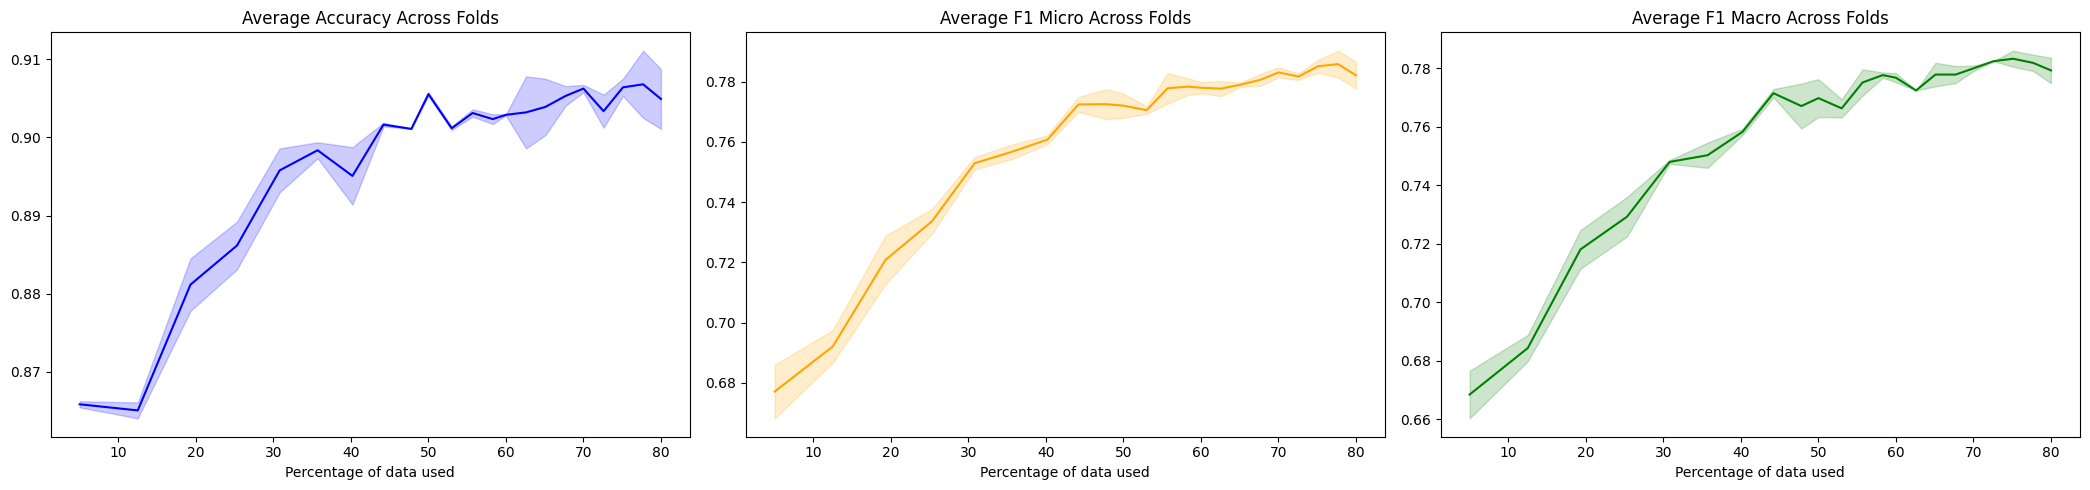

In [15]:
import matplotlib.pyplot as plt
import numpy as np

common_data_points = sorted(list(set(point for fold_points in all_fold_data_used for point in fold_points)))

# Interpolate metrics for each fold to the common data points
avg_accuracies = []
avg_f1_micros = []
avg_f1_macros = []
std_accuracies = []
std_f1_micros = []
std_f1_macros = []

for point in common_data_points:
    point_accuracies = []
    point_f1_micros = []
    point_f1_macros = []
    for i in range(2):
        sorted_indices = np.argsort(all_fold_data_used[i])
        sorted_data = np.array(all_fold_data_used[i])[sorted_indices]
        
        sorted_acc = np.array(all_fold_accuracies[i])[sorted_indices]
        sorted_f1m = np.array(all_fold_f1_micros[i])[sorted_indices]
        sorted_f1ma = np.array(all_fold_f1_macros[i])[sorted_indices]
        
        # Use interpolation to estimate the metric value at the common 'point'
        point_accuracies.append(np.interp(point, sorted_data, sorted_acc))
        point_f1_micros.append(np.interp(point, sorted_data, sorted_f1m))
        point_f1_macros.append(np.interp(point, sorted_data, sorted_f1ma))
    
    avg_accuracies.append(np.mean(point_accuracies))
    avg_f1_micros.append(np.mean(point_f1_micros))
    avg_f1_macros.append(np.mean(point_f1_macros))
    
    std_accuracies.append(np.std(point_accuracies))
    std_f1_micros.append(np.std(point_f1_micros))
    std_f1_macros.append(np.std(point_f1_macros))

# Convert to numpy arrays for easier plotting
avg_accuracies = np.array(avg_accuracies)
avg_f1_micros = np.array(avg_f1_micros)
avg_f1_macros = np.array(avg_f1_macros)
std_accuracies = np.array(std_accuracies)
std_f1_micros = np.array(std_f1_micros)
std_f1_macros = np.array(std_f1_macros)

fig, axs = plt.subplots(1, 3, figsize=(21, 5))
data_used_percent = [round(data / len(X) * 100, 1) for data in common_data_points]

# Plot for Accuracy
axs[0].plot(data_used_percent, avg_accuracies, label="Avg Accuracy", color="blue")
axs[0].fill_between(data_used_percent, avg_accuracies - std_accuracies, avg_accuracies + std_accuracies, color='blue', alpha=0.2)
axs[0].set_xlabel("Percentage of data used")
axs[0].set_title("Average Accuracy Across Folds")

# Plot for F1 Micro
axs[1].plot(data_used_percent, avg_f1_micros, label="Avg F1 Micro", color="orange")
axs[1].fill_between(data_used_percent, avg_f1_micros - std_f1_micros, avg_f1_micros + std_f1_micros, color='orange', alpha=0.2)
axs[1].set_xlabel("Percentage of data used")
axs[1].set_title("Average F1 Micro Across Folds")

# Plot for F1 Macro
axs[2].plot(data_used_percent, avg_f1_macros, label="Avg F1 Macro", color="green")
axs[2].fill_between(data_used_percent, avg_f1_macros - std_f1_macros, avg_f1_macros + std_f1_macros, color='green', alpha=0.2)
axs[2].set_xlabel("Percentage of data used")
axs[2].set_title("Average F1 Macro Across Folds")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

for i in range(2):
    result = pd.DataFrame({
        'Data Used': all_fold_data_used[i],
        'Accuracy': all_fold_accuracies[i],
        'F1 Micro': all_fold_f1_micros[i],
        'F1 Macro': all_fold_f1_macros[i],
    })

    result.to_csv(f'results/{filename}-{i+4}-results.csv', index=False)